A classification problem. 
Predict handwritten numbers. 
Train model with the MNIST dataset from openml.org. 

In [3]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib

# Downloading dataset

In [11]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

In [ ]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [12]:
# Split the data into `X` and `y`, and then into train and test sets.
# y is string and need to be converted into int. 
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]

X_test = X[60000:70000]
y_test = y[60000:70000]

# A smaller dataset for training and hyperparameter tuning. For faster runtime. 
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=0.5, stratify=y_train, random_state=42)

# EDA

In [6]:
# NAN-values
print(np.isnan(X_train).sum())
print(np.isnan(y_train).sum())
print(np.isnan(X_test).sum())
print(np.isnan(y_test).sum())

# No NAN-values

0
0
0
0


In [8]:
# Dataset structure
print(X_train.shape)
print(y_train.shape)

print(X_train_small.shape)
print(y_train_small.shape)

# 60 000 pictures in training data. 784 features = 784 pixlar = 28 x 28 pixlar. 
print(X_train[:15])
# from 0 (white) to 255 (black). 

(60000, 784)
(60000,)
(30000, 784)
(30000,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


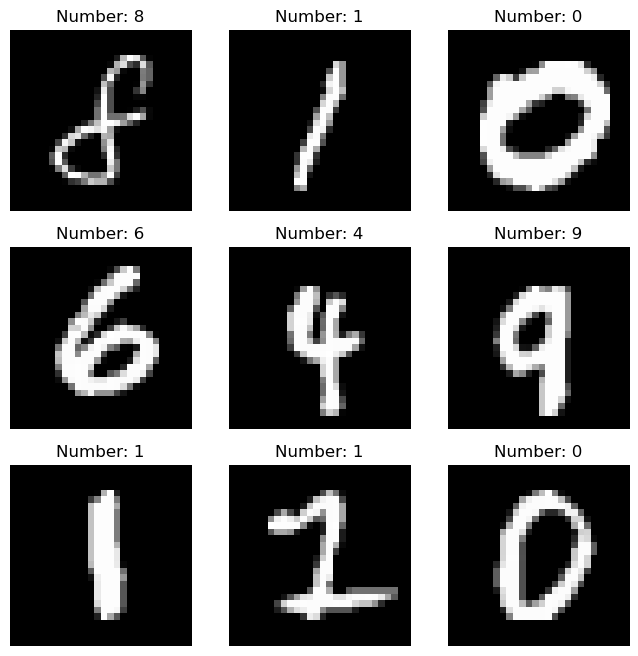

In [ ]:
# 9 random pictures from the training dataset. 

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    index = np.random.randint(0, X_train.shape[0])
    image = X_train[index].reshape(28, 28)
    ax.imshow(image, cmap="gray")
    ax.set_title(f"Number: {y_train[index]}")
    ax.axis("off")
plt.show()

# White numbers on a black canvas. 

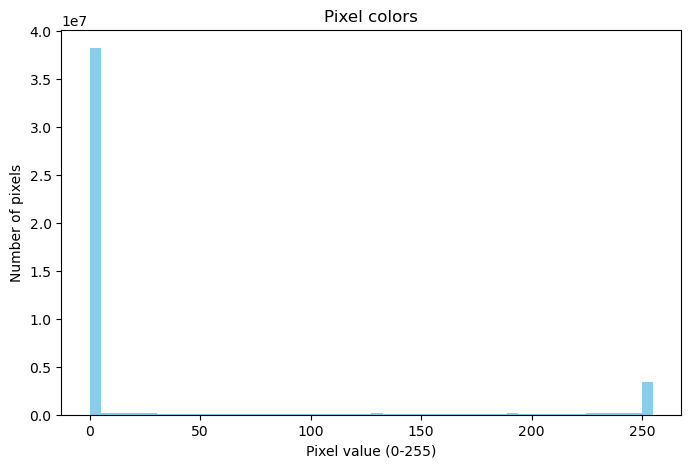

In [ ]:
# Pixel colors (0-255)
pixel_values = X_train.flatten()

plt.figure(figsize=(8, 5))
plt.hist(pixel_values, bins=50, color="skyblue")
plt.xlabel("Pixel value (0-255)")
plt.ylabel("Number of pixels")
plt.title("Pixel colors")
plt.show()

# White numbers on a black canvas. 

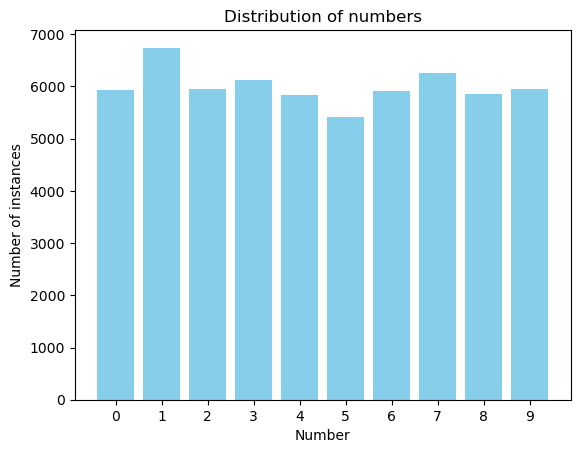

In [10]:
# Distribution of numbers in the training data
counts = np.bincount(y_train)
digits = np.arange(len(counts))

plt.bar(digits, counts, color="skyblue")
plt.xlabel("Number")
plt.ylabel("Number of instances")
plt.title("Distribution of numbers")
plt.xticks(digits)
plt.show()

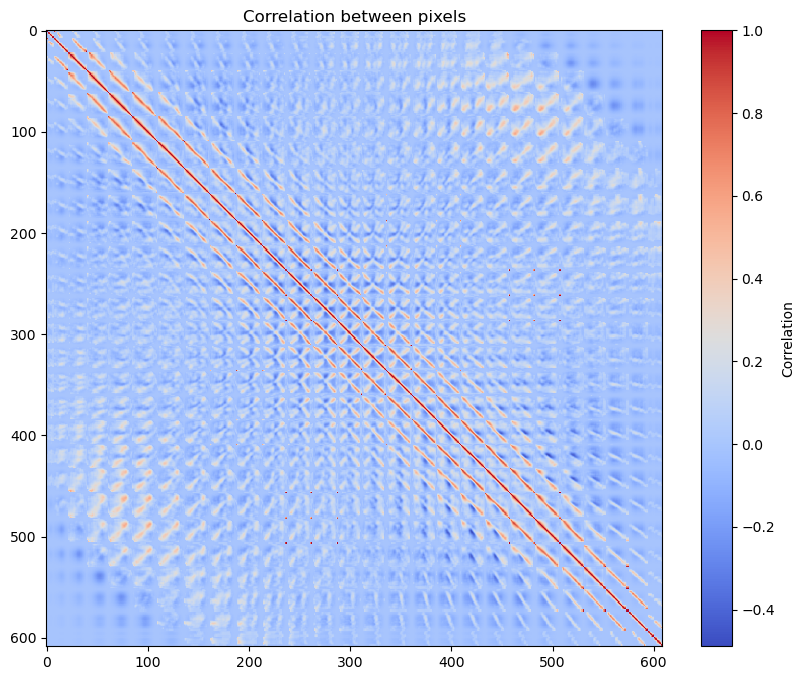

In [ ]:
# Correlation / Heatmap
subset = X_train[:1000]  # Subset of training data for speed

valid_columns = np.std(subset, axis=0) > 0
subset_filtered = subset[:, valid_columns] 

corr_matrix = np.corrcoef(subset_filtered, rowvar=False) 

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.title("Correlation between pixels")
plt.show()

# Most of the heatmap is light blue, which indicates that there is no korrelation between pixels. The background. Black in all pictures. 
# Red lines indicates the pixels close to eachother are highely correlated. The numbers. Dimensionality reduction can be a good idea. 
# Dimensionality reduction might be a good idea? Try for logistiic regression and SVM.

# Data pre-processing

In [13]:
# Normalization
# Important for logistic regression and SVM. Not really necessary for Random Forest and XGBoost. Using normalized data for all models. 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For training and hyperparameter tuning.
X_train_small_scaled = scaler.transform(X_train_small)

# For training for Streamlit-app
X_scaled = scaler.fit_transform(X)
# For Streamlit-app
joblib.dump(scaler, "mnist_scaler.pkl")

['mnist_scaler.pkl']

In [14]:
# Dimensionality reduction - PCA
# Variance: 95%
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# For training and hyperparameter tuning.
X_train_small_pca = pca.transform(X_train_small_scaled)

print(f"Antal komponenter som behövs för 95% varians: {pca.n_components_}")

Antal komponenter som behövs för 95% varians: 331


# Models

In [15]:
# k-fold cv
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# Logistic regression
# Without PCA
log_reg = LogisticRegression(max_iter=1000, solver="lbfgs", multi_class="multinomial")
log_reg_score = cross_val_score(log_reg, X_train_small_scaled, y_train_small, cv=cv, scoring="accuracy")

print(f"Logistic regression - Mean Accuracy: {log_reg_score.mean():.4f} ± {log_reg_score.std():.4f}")

Logistic regression - Mean Accuracy: 0.8937 ± 0.0032


In [17]:
# Logistic regression 
# With PCA
log_reg_PCA = LogisticRegression(max_iter=1000, solver="lbfgs", multi_class="multinomial")
log_reg_PCA_score = cross_val_score(log_reg_PCA, X_train_small_pca, y_train_small, cv=cv, scoring="accuracy")

print(f"Logistic regression with PCA - Mean Accuracy: {log_reg_PCA_score.mean():.4f} ± {log_reg_PCA_score.std():.4f}")

Logistic regression with PCA - Mean Accuracy: 0.9110 ± 0.0029


In [18]:
# SVM
# With PCA
svm_model = SVC()

param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"]
}
SVM_grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring="accuracy")
SVM_grid_search.fit(X_train_small_pca, y_train_small)

best_svm = SVM_grid_search.best_estimator_
SVM_score = cross_val_score(best_svm, X_train_small_pca, y_train_small, cv=cv, scoring="accuracy")

print(f"SVM - Mean Accuracy: {SVM_score.mean():.4f} ± {SVM_score.std():.4f}")

SVM - Mean Accuracy: 0.9633 ± 0.0023


In [21]:
# XGBoost
# Without PCA
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax", num_class=10, eval_metric="mlogloss"
)

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.3],
}
xgb_grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring="accuracy", verbose=0, n_jobs=2)
xgb_grid_search.fit(X_train_small_scaled, y_train_small)

best_xgb_clf = xgb_grid_search.best_estimator_
xgb_score = cross_val_score(best_xgb_clf, X_train_small_scaled, y_train_small, cv=cv, scoring="accuracy")

print(f"XGB - Mean Accuracy: {xgb_score.mean():.4f} ± {xgb_score.std():.4f}")

XGB - Mean Accuracy: 0.9686 ± 0.0026


In [22]:
# Random forest
# Without PCA

rf_clf = RandomForestClassifier(random_state=42, n_jobs=2)

param_grid = {
    "n_estimators": [50, 100, 200]
}
rf_grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring="accuracy", verbose=0, n_jobs=2)
rf_grid_search.fit(X_train_scaled, y_train)

best_rf_clf = rf_grid_search.best_estimator_
rf_score = cross_val_score(best_rf_clf, X_train_small_scaled, y_train_small, cv=cv, scoring="accuracy")

print(f"Random Forest - Mean Accuracy: {rf_score.mean():.4f} ± {rf_score.std():.4f}")

Random Forest - Mean Accuracy: 0.9614 ± 0.0013


In [23]:
# Model selection

results = {
    "Logistic Regression": (log_reg_score.mean(), log_reg_score.std()),
    "Logistic Regression with PCA": (log_reg_PCA_score.mean(), log_reg_PCA_score.std()),
    "SVM": (SVM_score.mean(), SVM_score.std()),
    "XGBoost": (xgb_score.mean(), xgb_score.std()),
    "Random Forest": (rf_score.mean(), rf_score.std())
}

print("Model selection")
for name, (mean_acc, std_acc) in results.items():
    print(f"{name}: {mean_acc:.4f} ± {std_acc:.4f}")
    
# XGBoost performs best.

Model selection
Logistic Regression: 0.8937 ± 0.0032
Logistic Regression with PCA: 0.9110 ± 0.0029
SVM: 0.9633 ± 0.0023
XGBoost: 0.9686 ± 0.0026
Random Forest: 0.9614 ± 0.0013


# Evaluation

In [24]:
final_model = best_xgb_clf
final_model.fit(X_train_scaled, y_train)

y_pred = final_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Test accuracy is a bit higher than for the training accuracy, which is to be expected since the model has been trained on more data. 

Test Accuracy: 0.9804


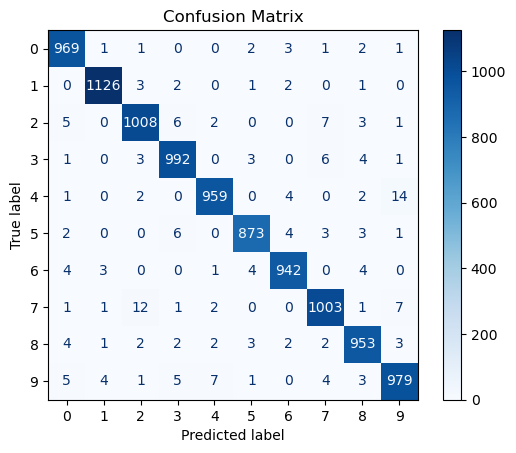

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

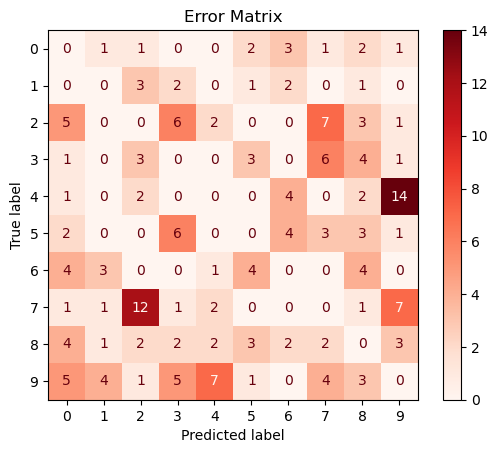

In [26]:
# Error matrix
error_matrix = cm.copy()
np.fill_diagonal(error_matrix, 0)

disp = ConfusionMatrixDisplay(confusion_matrix=error_matrix, display_labels=np.arange(10))
disp.plot(cmap="Reds")
plt.title("Error Matrix")
plt.show()

In [27]:
errors_per_digit = error_matrix.sum(axis=1)
most_misclassified_digit = np.argmax(errors_per_digit)

print(f"The number that is missclassified the most number of times: {most_misclassified_digit}")

The number that is missclassified the most number of times: 9


For Streamlit app

In [ ]:
production_model = best_xgb_clf
production_model.fit(X_scaled, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=10, ...)

In [ ]:
# Save model
joblib.dump(production_model, "mnist_XGBoost_model.pkl")

['mnist_XGBoost_model.pkl']